# Introduction
A generative model takes data (supposedly belonging to some distribution) and generates samples that belong to the same distribution.

Generative Adversarial Networks (GANs) are a prominent approach to generative AI.

# Why?
Generative models have a wide range of application. One can enhance images, create images, remove artifacts from images, generate simulations, and more using generative models.

[[1]](#1)

# How?
A GAN, as its name suggests, is composed of two networks, the generator and the discriminator, which are "adversaries". The generator takes in a vector of noise and produces a synthetic image and the discriminator takes in an image and predicts whether the image is real (from data) or fake (from the generator).

## Analogy
An intuitive analogy is the situation of a forger trying to create a fake Picasso painting to be authenticated by an art dealer. The forger mixes their initial batch of fake paintings with real Picasso paintings and has them checked by the art dealer, who gives the forger feedback about what makes a Picasso a Picasso. The forger goes back, makes some more fakes with the feedback they received, and repeats the process. As time goes on, the forger gets better and better at producing works similar to Picasso's and the art dealer gets better and better at spotting fake Picasso works.

## Models
The discriminator is a CNN, as you are already familiar with. It is composed of convolution layers which typically reduce the spatial dimensions of the input, or leave them unchanged. We can design it ourselves using CNN design philosophies, apply transfer learning, etc.

We can't use traditional convolution layers for our generator because we plan to upsample noise into an image. What kind of layer can increase the spatial dimensions of its input? Transposed (fractionally-strided) convolutions solve this problem. Transposed convolutions are a kind of reverse convolution. Thus, the generator is made up of transpose convolutions.

A visualization of transpose convolutions is given below. The bottom image is the input and the top image is the output.
<div>
<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*kOThnLR8Fge_AJcHrkR3dg.gif" width="700"/>
</div>

## Training
<div>
<img src="https://idiotdeveloper.com/wp-content/uploads/2023/08/gan-1024x354.webp" width="700"/>
</div>

We do not train the generator and the discriminator at the same time. While training the generator, the discriminator is frozen, and vice versa.

The discriminator is trained with the goal of $P(y=\text{real}|x)=1,P(y=\text{real}|G(z))=0$, where $G(z)$ is a generated image given some noise vector, $z$. The generator is trained with the goal of $P(y=\text{real}|G(z))=1$. Thus, $V$, our objective function, w.r.t. $D$ is maximized when $D(x)=1$ and $D(G(z))=0$ and $V$ w.r.t. $G$ is minimized when $D(G(z))=1$

This optimization problem can be written as:
$$
\min_G\max_D V(D,G)=\mathbb{E}_{x\sim p_\text{data}(x)}[\log D(x)]+\mathbb{E}_{z\sim p_z(z)}[\log (1-D(G(z)))]
$$

Further detail is left to the reader.

[[1]](#1), [[2]](#2)

# Visualization
Returning to our earlier statistical definition of generative models, GANs can be visualized as such:

<div>
<img src="https://cs.stanford.edu/people/karpathy/gan/gan.png" width="900"/>
</div>

The blue, dotted line gives the output of the discriminator, $D(.)\in[0,1]$. The green, solid line gives the distribution of the generated data, $P(G(z))$. The black, dotted line gives the distribution of the real data, $P(x)$. Below the curves, noise $z$ is mapped to the real space, $x$ (notice how the green curve peaks near the average of the resultant mappings).

The green curve is attemping to match the black curve. Initially, the model does not model the real distribution very well, and the discriminator is easily able to distinguish between the real and fake distributions. Over time, the model is able to match the real distribution better and better, and at the end, the discriminator is completely unable to distinguish between real and fake, with $D(.)=1/2$ for all inputs (the best it can do is guess).

Note that the final visualization, where $D(.)=1/2$, is only an ideal.

An intriguing live demo is given here: https://cs.stanford.edu/people/karpathy/gan/.

[[1]](#1), [[3]](#3)

# Bag of Tricks
The process of training and tuning GANs is notoriously difficult. Here are a number of tricks that one can use when implementing GANs.

1. Use `tanh` rather than `sigmoid` as the last activation of the generator.
2. Sample points from the latent space (noise) from a normal distribution.
3. Introduce stochasticity (randomness) by using dropout in the discriminator and adding noise to the labels for the discrimintor.
4. Prevent sparse gradients (typically desired, but not in GANs) by using strided convolutions, rather than max pooling, for downsampling and using `LeakyReLU` rather than `ReLU`.
5. To fix checkerboard artifacts, use a kernel size that's divisible by the stride size in both the generator and the discriminator.

[[2]](#2)

# Example
A simple demonstration of a GAN is given here. Using a dataset of paper images, we will train a GAN to generate paper-like images.

The dataset was retrieved from: https://www.kaggle.com/datasets/farzadnekouei/trash-type-image-dataset

## Environment Setup

### Imports

In [ ]:
import os
import time
import urllib
import zipfile

import imageio
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
from tensorflow.keras import layers, Model

from IPython import display

2024-09-05 13:15:31.167999: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-05 13:15:31.192076: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-05 13:15:31.213731: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-05 13:15:31.220329: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-05 13:15:31.235929: I tensorflow/core/platform/cpu_feature_guar

### Set Random Seed

In [ ]:
# tf.random.set_seed(0)

## Data

### Fetch

In [ ]:
cwd = os.getcwd()

if not os.path.exists(cwd + "/gan_demo_data"):
    data_url = "https://g-2aaf39.eeb47.a567.data.globus.org/gan_demo_data.zip"

    filename, _ = urllib.request.urlretrieve(data_url)
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(cwd)

### Initialize Dataset

In [ ]:
# Read in data
path = cwd + "/gan_demo_data"

# to be used again later...
IMG_SIZE = (384, 384)
BATCH_SIZE = 128

dataset = tf.keras.utils.image_dataset_from_directory(
    path,
    labels=None,
    label_mode=None,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True
)

Found 501 files.


2024-09-05 13:15:37.184145: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22811 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:3b:00.0, compute capability: 7.5
2024-09-05 13:15:37.185651: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22811 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:5e:00.0, compute capability: 7.5


Normalize the images to $[-1,1]$

In [ ]:
def preprocess_dataset(images):
    return images / 127.5 - 1

dataset = dataset.map(preprocess_dataset)

### Split Dataset

In [ ]:
# Split the data into Training, Validation, and Test sets
def splits(dataset, train_ratio, val_ratio, test_ratio):
    Data_size = len(dataset)
    train_size = int(train_ratio * Data_size)
    val_size = int(val_ratio * Data_size)
    test_size = int(test_ratio * Data_size)

    train_dataset = dataset.take(train_size)
    val_test_dataset = dataset.skip(train_size)
    val_dataset = val_test_dataset.take(val_size)
    test_dataset = val_test_dataset.skip(val_size).take(test_size)

    return train_dataset, val_dataset, test_dataset

train_ratio = 0.80*0.80
val_ratio = 0.80*0.20
test_ratio = 0.20

train_dataset, val_dataset, test_dataset = splits(dataset, train_ratio, val_ratio, test_ratio)

### Visualization

2024-09-05 13:15:40.342546: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


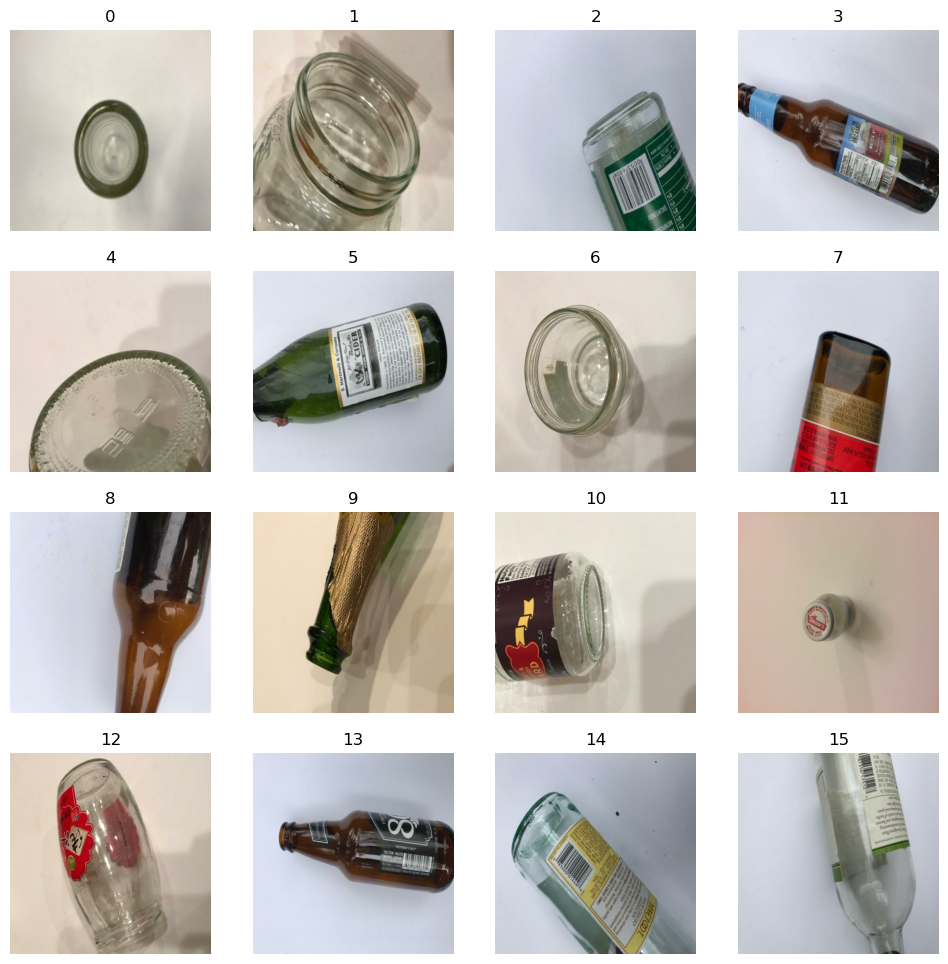

In [ ]:
plt.figure(figsize = (12,12))

for images in dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    # map [-1, 1] -> [0, 1]
    plt.imshow((images[i] + 1)/2)
    plt.title(i)
    plt.axis("off")

## Model

### Generator

In [ ]:
class Generator(Model):
    def __init__(self):
        super().__init__()

        self.stack = tf.keras.Sequential([
            layers.InputLayer((100,)),
            layers.Dense(6*6*BATCH_SIZE, use_bias=False),
            layers.BatchNormalization(),
            layers.LeakyReLU(),

            layers.Reshape((6, 6, BATCH_SIZE)),
            # (None, 6, 6, 128)

            layers.Conv2DTranspose(
                BATCH_SIZE,
                (5, 5),
                strides=(1, 1),
                padding='same',
                use_bias=False
            ),
            # (None, 6, 6, 128)
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Conv2DTranspose(
                BATCH_SIZE,
                (5, 5),
                strides=(1, 1),
                padding='same',
                use_bias=False
            ),
            # (None, 6, 6, 128)
            layers.BatchNormalization(),
            layers.LeakyReLU(),

            layers.Conv2DTranspose(
                BATCH_SIZE//2,
                (5, 5),
                strides=(2, 2),
                padding='same',
                use_bias=False
            ),
            # (None, 12, 12, 64)
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Conv2DTranspose(
                BATCH_SIZE//2,
                (5, 5),
                strides=(1, 1),
                padding='same',
                use_bias=False
            ),
            # (None, 12, 12, 64)
            layers.BatchNormalization(),
            layers.LeakyReLU(),

            layers.Conv2DTranspose(
                BATCH_SIZE//2,
                (5, 5),
                strides=(2, 2),
                padding='same',
                use_bias=False,
                activation='tanh'
            ),
            # (None, 24, 24, 64)
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Conv2DTranspose(
                BATCH_SIZE//2,
                (5, 5),
                strides=(1, 1),
                padding='same',
                use_bias=False,
                activation='tanh'
            ),
            # (None, 24, 24, 64)
            layers.BatchNormalization(),
            layers.LeakyReLU(),

            layers.Conv2DTranspose(
                BATCH_SIZE//4,
                (5, 5),
                strides=(2, 2),
                padding='same',
                use_bias=False,
                activation='tanh'
            ),
            # (None, 48, 48, 32)
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Conv2DTranspose(
                BATCH_SIZE//4,
                (5, 5),
                strides=(1, 1),
                padding='same',
                use_bias=False,
                activation='tanh'
            ),
            # (None, 48, 48, 32)
            layers.BatchNormalization(),
            layers.LeakyReLU(),

            layers.Conv2DTranspose(
                BATCH_SIZE//8,
                (5, 5),
                strides=(2, 2),
                padding='same',
                use_bias=False,
                activation='tanh'
            ),
            # (None, 96, 96, 16)
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Conv2DTranspose(
                BATCH_SIZE//8,
                (5, 5),
                strides=(1, 1),
                padding='same',
                use_bias=False,
                activation='tanh'
            ),
            # (None, 96, 96, 16)
            layers.BatchNormalization(),
            layers.LeakyReLU(),

            layers.Conv2DTranspose(
                BATCH_SIZE//16,
                (5, 5),
                strides=(2, 2),
                padding='same',
                use_bias=False,
                activation='tanh'
            ),
            # (None, 192, 192, 8)
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Conv2DTranspose(
                BATCH_SIZE//16,
                (5, 5),
                strides=(1, 1),
                padding='same',
                use_bias=False,
                activation='tanh'
            ),
            # (None, 192, 192, 8)
            layers.BatchNormalization(),
            layers.LeakyReLU(),

            layers.Conv2DTranspose(
                BATCH_SIZE//32,
                (5, 5),
                strides=(2, 2),
                padding='same',
                use_bias=False,
                activation='tanh'
            ),
            # (None, 384, 384, 4)
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Conv2DTranspose(
                BATCH_SIZE//32,
                (5, 5),
                strides=(1, 1),
                padding='same',
                use_bias=False,
                activation='tanh'
            ),
            # (None, 384, 384, 4)
            layers.BatchNormalization(),
            layers.LeakyReLU(),

            layers.Conv2DTranspose(
                3,
                (5, 5),
                strides=(1, 1),
                padding='same',
                use_bias=False,
                activation='tanh'
            ),
            # (None, 384, 384, 3)
            layers.BatchNormalization(),
            layers.Activation('tanh')
        ])

    def call(self, x):
        x = self.stack(x)
        return x

Let's see an image the untrained generator generates.

2024-09-05 13:15:42.691641: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1725556542.777059  746878 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725556542.799407  746878 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725556542.800518  746878 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725556542.801002  746878 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725556542.801523  746878 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725556542.802919  746878 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725556542.824348  746878 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725556542.841780  746878 gpu_t

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 384, 384, 3)    │     1,915,272 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,915,272 (7.31 MB)

 Trainable params: 1,904,786 (7.27 MB)

 Non-trainable params: 10,486 (40.96 KB)

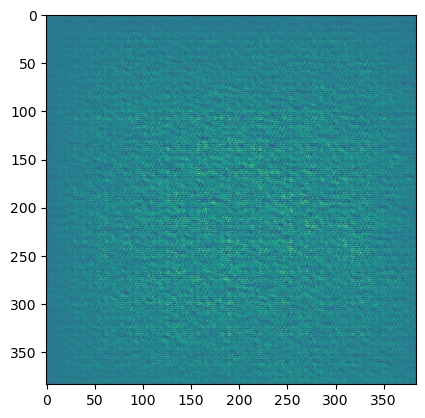

In [ ]:
generator = Generator()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])
generator.summary()

### Discriminator

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)

class Discriminator(Model):
    def __init__(self):
        super().__init__()

        self.stack = tf.keras.Sequential([
            layers.InputLayer(IMG_SHAPE),
            # 384 384 3

            layers.Conv2D(
                16,
                (5, 5),
                strides=(2, 2),
                padding='same',
            ),
            # 192 192 16
            layers.LeakyReLU(),
            layers.Dropout(0.3),

            # layers.Conv2D(
            #     32,
            #     (5, 5),
            #     strides=(2, 2),
            #     padding='same',
            # ),
            # # 96 96 32
            # layers.LeakyReLU(),
            # layers.Dropout(0.3),

            layers.Conv2D(
                64,
                (5, 5),
                strides=(2, 2),
                padding='same',
            ),
            # 48 48 64
            layers.LeakyReLU(),
            layers.Dropout(0.3),

            # layers.Conv2D(
            #     128,
            #     (5, 5),
            #     strides=(2, 2),
            #     padding='same',
            # ),
            # # 24 24 128
            # layers.LeakyReLU(),
            # layers.Dropout(0.3),

            layers.Conv2D(
                256,
                (5, 5),
                strides=(2, 2),
                padding='same',
            ),
            # 12 12 256
            layers.LeakyReLU(),
            layers.Dropout(0.3),

            # layers.Conv2D(
            #     512,
            #     (5, 5),
            #     strides=(2, 2),
            #     padding='same',
            # ),
            # # 6 6 512
            # layers.LeakyReLU(),
            # layers.Dropout(0.3),

            layers.Conv2D(
                1024,
                (5, 5),
                strides=(2, 2),
                padding='same',
            ),
            # 3 3 1024
            layers.LeakyReLU(),
            layers.Dropout(0.3),

            layers.Flatten(),
            layers.Dense(1)
        ])

    def call(self, x):
        x = self.stack(x)
        return x

In [ ]:
discriminator = Discriminator()
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 1)              │     7,581,185 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,581,185 (28.92 MB)

 Trainable params: 7,581,185 (28.92 MB)

 Non-trainable params: 0 (0.00 B)

## Define Loss and Optimizers

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define Training Loop
Training a GAN isn't as simple as training a regular neural network. We must define the training steps ourself.

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                epoch + 1,
                                seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                            epochs,
                            seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')

  # plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

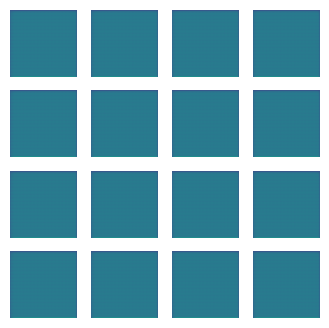

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

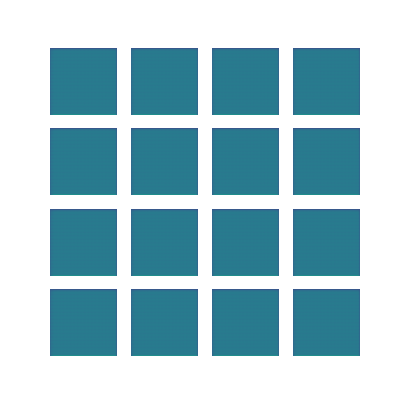

In [ ]:
display_image(EPOCHS)

# References
1. H. Venkateswara. Introduction to Deep Learning. 2024.
2. F. Chollet. Deep Learning with Python. 2017. Available: https://sourestdeeds.github.io/pdf/Deep%20Learning%20with%20Python.pdf
3. I. Goodfellow et al. Generative Adversarial Networks. 2014. Available: https://arxiv.org/abs/1406.2661